<div style='background-image:  url("https://tinyurl.com/587zdbkm/title01.png") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computational Seismology</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Finite Volume Method - 1D Elastic Wave Equation</div>
        </div>
    </div>
</div>

## Exercise
* Play around with CFL Limit, frequency range (initial condition)


## Basic Equations

The source free elastic wave equation can be written in terms of a coupled first-order system 

\begin{align}
\partial_t \sigma - \mu \partial_x v & = 0 \\ 
\partial_t v - \frac{1}{\rho} \partial_x \sigma & = 0
\end{align}

with $\rho$ the density and $\mu$ the shear modulus. This equation in matrix-vector notation follows

\begin{equation}
\partial_t \mathbf{Q} + \mathbf{A} \partial_x \mathbf{Q} = 0
\end{equation}

where $\mathbf{Q} = (\sigma, v)$ is the vector of unknowns and the matrix $\mathbf{A}$ contains the parameters $\rho$ and $\mu$. The above matrix equation is analogous to the advection equation $\partial_t q + a \partial_x q = 0$. Although it is a coupled system, diagonalization of $\mathbf{A} = \mathbf{R}^{-1}\mathbf{\Lambda}\mathbf{R}$ allows us to implement all elements developed for the solution of the advection equation in terms of fluxes. It turns out that the decoupled version is

\begin{equation}
\partial_t \mathbf{W} + \mathbf{\Lambda} \partial_x \mathbf{W} = 0
\end{equation}

where the eigenvector matrix $\mathbf{R}$ and the diagonal matrix of eigenvalues $\mathbf{\Lambda}$ are given

\begin{equation}
\mathbf{W} = \mathbf{R}^{-1}\mathbf{Q}
\qquad\text{,}\qquad
\mathbf{\Lambda}=
     \begin{pmatrix}
       -c & 0 \\
        0 & c 
     \end{pmatrix}
\qquad\text{,}\qquad
\mathbf{R} =  
     \begin{pmatrix}
       Z & -Z \\
       1 &  1 
     \end{pmatrix}
\qquad\text{and}\qquad
\mathbf{R}^{-1} = \frac{1}{2Z}
     \begin{pmatrix}
       1 & Z \\
      -1 & Z 
     \end{pmatrix}
\end{equation}

Here $Z = \rho c$ with $c = \sqrt{\mu/\rho}$ represents the seismic impedance. 

This notebook implements both upwind and Lax-Wendroff schemes for solving the free source version of the elastic wave equation in a homogeneous media. To keep the problem simple we use as spatial initial condition a Gauss function with half-width $\sigma$

\begin{equation}
Q(x,t=0)  = e^{-1/\sigma^2 (x - x_{o})^2}
\end{equation}

In [6]:
# Import all necessary libraries, this is a configuration step for the exercise.
# Please run it before the simulation code!
import numpy as np
import matplotlib
%matplotlib widget

import matplotlib.pyplot as plt
import matplotlib.animation as animation


### 1. Initialization of setup

In [7]:
# Initialization of setup
# --------------------------------------------------------------------------
nx    = 800        # number of grid points 
c     = 2500       # acoustic velocity in m/s
ro    = 2500       # density in kg/m^3
Z     = ro*c       # impedance
mu    = ro*c**2    # shear modulus

xmax  = 10000      # Length in m 
eps   = 0.5        # CFL
tmax  = 0.3        # simulation time in s
isnap = 10         # plotting rate
sig   = 200        # argument in the inital condition
x0    = 5000       # position of the initial condition

imethod = 'Lax-Wendroff'  # 'Lax-Wendroff', 'upwind'

# Initialize Space
x, dx = np.linspace(0,xmax,nx,retstep=True)

# use wave based CFL criterion
dt = eps*dx/c    # calculate time step from stability criterion

# Simulation time
nt = int(np.floor(tmax/dt))

# Initialize wave fields
Q = np.zeros((2,nx))
Qnew = np.zeros((2,nx))
Qa = np.zeros((2,nx))

### 2. Initial condition

Seismic disturbances are introduced through specification of a particular spatial initial condition, in this case we use a Gaussian function. 

Implementation of the spatial initial condition given by:

\begin{equation}
Q(x,t=0)  = e^{-1/\sigma^2 (x - x_{o})^2}
\end{equation}

Visualize the initial condition 

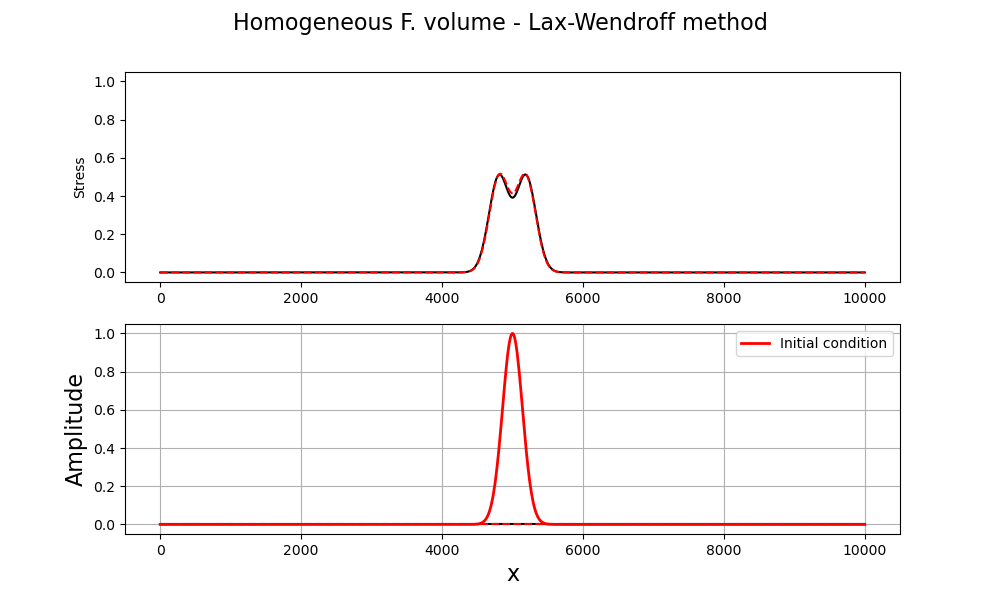

In [8]:
# Initial condition
# --------------------------------------------------------------------------
sx = np.exp(-1./sig**2 * (x-x0)**2)
Q[0,:] = sx

# ---------------------------------------------------------------
# Plot initial condition
# ---------------------------------------------------------------
plt.plot(x, sx, color='r', lw=2, label='Initial condition')
plt.ylabel('Amplitude', size=16)
plt.xlabel('x', size=16)
plt.legend()
plt.grid(True)
plt.show()

### 3. Solution for the homogeneous problem

#### Upwind finite volume scheme
We decompose the solution into right propagating $\mathbf{\Lambda}^{+}$ and left propagating eigenvalues $\mathbf{\Lambda}^{-}$ where

\begin{equation}
\mathbf{\Lambda}^{+}=
     \begin{pmatrix}
       -c & 0 \\
        0 & 0 
     \end{pmatrix}
\qquad\text{,}\qquad
\mathbf{\Lambda}^{-}=
     \begin{pmatrix}
        0 & 0 \\
        0 & c 
     \end{pmatrix}
\qquad\text{and}\qquad
\mathbf{A}^{\pm} = \mathbf{R}^{-1}\mathbf{\Lambda}^{\pm}\mathbf{R}
\end{equation}

This strategy allows us to formulate an upwind finite volume scheme for any hyperbolic system as 

\begin{equation}
\mathbf{Q}_{i}^{n+1}  = \mathbf{Q}_{i}^{n} - \frac{dt}{dx}(\mathbf{A}^{+}\Delta\mathbf{Q}_{l} - \mathbf{A}^{-}\Delta\mathbf{Q}_{r})
\end{equation}

with corresponding flux term given by

\begin{equation}
\mathbf{F}_{l} =  \mathbf{A}^{+}\Delta\mathbf{Q}_{l}
\qquad\text{,}\qquad
\mathbf{F}_{r}  =  \mathbf{A}^{-}\Delta\mathbf{Q}_{r}
\end{equation}

#### Lax-Wendroff finite volume scheme

The upwind solution presents a strong diffusive behaviour. In this sense, the Lax-Wendroff perform better, with the advantage that it is not needed to decompose the eigenvalues into right and left propagations. Here the matrix $\mathbf{A}$ can be used in its original form. The Lax-Wendroff follows

\begin{equation}
\mathbf{Q}_{i}^{n+1}  = \mathbf{Q}_{i}^{n} - \frac{dt}{2dx}\mathbf{A}(\mathbf{Q}_{i+1}^{n} - \mathbf{Q}_{i-1}^{n}) + \frac{1}{2}\Big(\frac{dt}{dx}\Big)^2\mathbf{A}^2(\mathbf{Q}_{i+1}^{n} - 2\mathbf{Q}_{i}^{n} + \mathbf{Q}_{i-1}^{n})
\end{equation} 

Initialization of all relevant matrices, i.e $R$, $R^{-1}$, $\mathbf{\Lambda}^{+}$, $\mathbf{\Lambda}^{-}$, $\mathbf{A}^{+}$, $\mathbf{A}^{-}$, $\mathbf{A}$. 

In [9]:
# Initialize all matrices
# --------------------------------------------------------------------------

R = np.array([[Z, -Z],[1, 1]])        # Eq. 8.43
Rinv = np.linalg.inv(R)               # Eq. 8.43
Lp = np.array([[0, 0], [0, c]])       # Eq. 8.49
Lm = np.array([[-c, 0], [0, 0]])      # Eq. 8.49
Ap = R @ Lp @ Rinv                    # Eq. 8.50     
Am = R @ Lm @ Rinv                    # Eq. 8.50    
A = np.array([[0, -mu], [-1/ro, 0]])  # Eq. 8.35

### 4. Finite Volumes solution

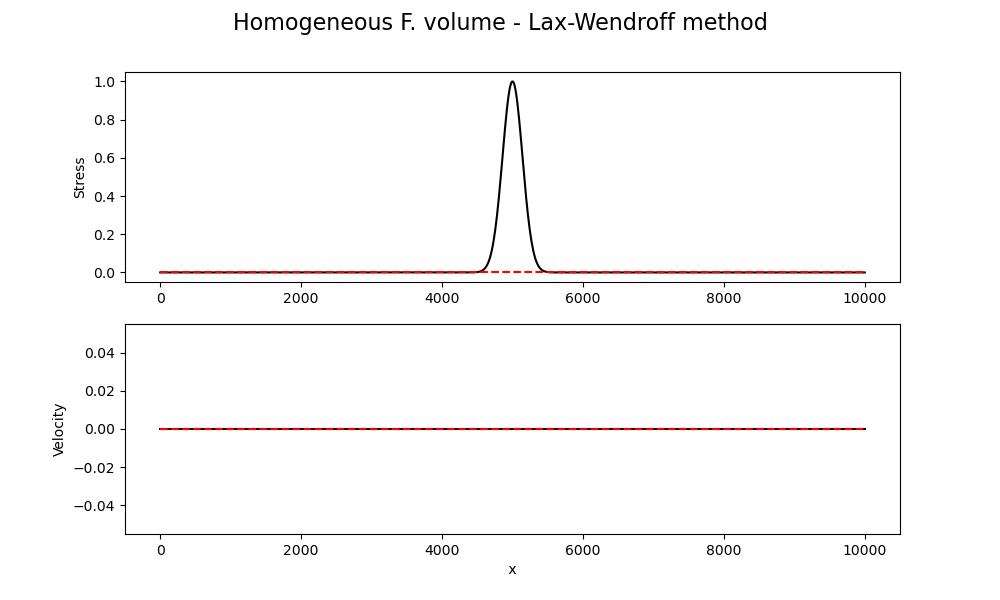

In [10]:
# Initialize animated plot
# ---------------------------------------------------------------
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
line1 = ax1.plot(x, Q[0,:], 'k', x, Qa[0,:], 'r--')
line2 = ax2.plot(x, Q[1,:], 'k', x, Qa[1,:], 'r--')
ax1.set_ylabel('Stress')
ax2.set_ylabel('Velocity')
ax2.set_xlabel(' x ')
plt.suptitle('Homogeneous F. volume - %s method'%imethod, size=16)

plt.ion()    # set interective mode
plt.show()

# ---------------------------------------------------------------
# Time extrapolation
# --------------------------------------------------------------- 

for i in range(nt): 
    if imethod =='Lax-Wendroff':        
        for j in range(1,nx-1):
            dQ1 = Q[:,j+1] - Q[:,j-1]
            dQ2 = Q[:,j-1] - 2*Q[:,j] + Q[:,j+1]
            Qnew[:,j] = Q[:,j] - 0.5*dt/dx*(A @ dQ1)\
            + 1./2.*(dt/dx)**2 * (A @ A) @ dQ2    # Eq. 8.56
            
        # Absorbing boundary conditions
        Qnew[:,0] = Qnew[:,1]
        Qnew[:,nx-1] = Qnew[:,nx-2]

    elif imethod == 'upwind': 
        for j in range(1,nx-1):
            dQl = Q[:,j] - Q[:,j-1]
            dQr = Q[:,j+1] - Q[:,j]
            Qnew[:,j] = Q[:,j] - dt/dx * (Ap @ dQl + Am @ dQr)  # Eq. 8.54
            
        # Absorbing boundary conditions 
        Qnew[:,0] = Qnew[:,1]
        Qnew[:,nx-1] = Qnew[:,nx-2]
    else:
        raise NotImplementedError

    Q, Qnew = Qnew, Q

    
    # --------------------------------------   
    # Animation plot. Display solution
    if not i % isnap: 
        for l in line1:
            l.remove()
            del l               
        for l in line2:
            l.remove()
            del l 
        # -------------------------------------- 
        # Analytical solution (stress i.c.)
        Qa[0,:] = 1./2.*(np.exp(-1./sig**2 * (x-x0 + c*i*dt)**2)\
        + np.exp(-1./sig**2 * (x-x0-c*i*dt)**2))

        Qa[1,:] = 1/(2*Z)*(np.exp(-1./sig**2 * (x-x0+c*i*dt)**2)\
        - np.exp(-1./sig**2 * (x-x0-c*i*dt)**2))
        
        # -------------------------------------- 
        # Display lines
        line1 = ax1.plot(x, Q[0,:], 'k', x, Qa[0,:], 'r--', lw=1.5)
        line2 = ax2.plot(x, Q[1,:], 'k', x, Qa[1,:], 'r--', lw=1.5)
        plt.legend(iter(line2), ('F. Volume', 'Analytic'))
        plt.gcf().canvas.draw()
